In [1]:
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import torch
import matplotlib.pyplot as plt
import imageio
from qutip import (fock, coherent, basis, destroy, qeye, tensor, wigner, mesolve, ptrace)

from scipy.ndimage import gaussian_filter
import pickle
import seaborn as sns

import skimage as ski
from skimage import measure

import glob
import os

## Task A

### Plotting

In [ ]:
wigner_files = sorted(glob.glob('../data/synthetic/noisy_wigner_*.pickle'))

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()
for i, file_path in enumerate(wigner_files):
  if i >= 16: 
    break
    
  data = pickle.load(open(file_path, 'rb'))
  
  x = np.array(data[0])
  y = np.array(data[1])
  wigner_data = np.array(data[2])
  
  base_name = os.path.basename(file_path).replace('.pickle', '')
  np.save(f'../data/synthetic_npy/{base_name}_x.npy', x)
  np.save(f'../data/synthetic_npy/{base_name}_y.npy', y)
  np.save(f'../data/synthetic_npy/{base_name}_wigner.npy', wigner_data)
  
  axes[i].set_title(f'Wigner {i}')
  axes[i].set_xlabel('')
  axes[i].set_ylabel('')
  axes[i].set_xticks([])
  axes[i].set_yticks([])


  # data cleaning
  edge_location = len(wigner_data) -1 
  b = (sum(wigner_data[edge_location, :]) + sum(wigner_data[:, edge_location]) + sum(wigner_data[0, :]) + sum(wigner_data[:, 0]))/(4 * edge_location)
  wigner_data = wigner_data - b

  wigner_data[np.isnan(wigner_data)] = 0

  wigner_integral = np.trapz(np.trapezoid(wigner_data, x), y)
  wigner_data = wigner_data/ wigner_integral

  wigner_data[np.isnan(wigner_data)] = 0

  sigma = 3
  wigner_data = gaussian_filter(wigner_data, sigma=sigma)
  sns.heatmap(abs(wigner_data), cmap='coolwarm', cbar=True, ax=axes[i])

  # sns.heatmap(wigner_data, cmap='coolwarm', cbar=False, ax=axes[i])

plt.tight_layout()
plt.show()

### Denoising

In [ ]:
data = pickle.load(open(wigner_files[14], 'rb'))
x = np.array(data[0])
y = np.array(data[1])
wigner_data = np.array(data[2])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(wigner_data, cmap='coolwarm', cbar=True, ax=ax)
ax.set_title('First Wigner')
plt.show()

# In most physical states, at the edges of phase space $W(x,p) \rightarrow0$.  This should allow you to estimate the value of $b$.
edge_location = len(wigner_data) -1 
b = (sum(wigner_data[edge_location, :]) + sum(wigner_data[:, edge_location]) + sum(wigner_data[0, :]) + sum(wigner_data[:, 0]))/(4 * edge_location)
wigner_data = wigner_data - b

# Normalize the Wigner function
wigner_integral = np.trapz(np.trapz(wigner_data, x), y)
wigner_data = wigner_data/ wigner_integral
print(f'Wigner integral: {wigner_integral}')


fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(wigner_data, cmap='coolwarm', cbar=True, ax=ax)
ax.set_title('Wigner')
plt.show()

In [ ]:
sigma = 3
wigner_data = gaussian_filter(wigner_data, sigma=sigma)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(abs(wigner_data), cmap='coolwarm', cbar=True, ax=ax)
ax.set_title('First Wigner (Gaussian filtered)')

wigner_integral_after = np.trapezoid(np.trapezoid(wigner_data, x), y)
print(f'Wigner integral after filtering: {wigner_integral_after}')

plt.show()

In [ ]:
# use contour finding from skimage to find the contours of the Wigner function
contours = measure.find_contours(abs(wigner_data), 0.05)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(wigner_data, cmap='coolwarm', interpolation='nearest')
for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.set_title('First Wigner (Gaussian filtered)')
print(f'Number of contours found: {len(contours)}')
plt.show()


## Task B

In [2]:
def gen_wigners(N, N_points=1000) -> list:
    """
    Generates N Wigner functions for coherent states with random amplitudes.
    """
    wigner_functions = []
    xvec = np.linspace(-5,5,1000)
    for i in range(N):
        alpha = np.random.rand() + 1j * np.random.rand()
        psi = (coherent(15, alpha) - coherent(15, -alpha)).unit()
        W_n = wigner(psi, xvec, xvec)
        wigner_functions.append(W_n)
    return wigner_functions

In [46]:
# write the noise models alice and ryan you bitches
def gauss(image):
  mean=0
  var=0.02
  (row, col) = np.shape(image)
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,size=(row,col))
  noisy = image + gauss
  return noisy

def sandp(image):
  s_vs_p=0.5
  amount=0.05
  (row, col) = np.shape(image)
  out = np.copy(image)

  # Number of salt pixels
  num_salt = int(np.ceil(amount * image.size * s_vs_p))
  row_coords = np.random.randint(0, row, num_salt)
  col_coords = np.random.randint(0, col, num_salt)
  out[row_coords, col_coords] = 1

  # Number of pepper pixels
  num_pepper = int(np.ceil(amount * image.size * (1.0 - s_vs_p)))
  row_coords_p = np.random.randint(0, row, num_pepper)
  col_coords_p = np.random.randint(0, col, num_pepper)
  out[row_coords_p, col_coords_p] = 0
  return out

def poisson(image):
  # Ensure we have no negative values
  clipped = np.clip(image, 0, None)
  # Count distinct values
  vals = len(np.unique(clipped))
  # Guard if everything is zero
  if vals < 2:
      return clipped
  # Use next power of two
  vals = 2 ** np.ceil(np.log2(vals))
  # Poisson sampling
  noisy = np.random.poisson(clipped * vals) / float(vals)
  return noisy

def speckle(image):
  (row, col) = np.shape(image)
  gauss = np.random.randn(row,col)     
  noisy = image + image * gauss
  return noisy

import scipy.ndimage
def convo(image):
  # Applies a 2D box filter (mean filter)
  kernel_size = 69
  kernel = np.ones((kernel_size, kernel_size)) / (kernel_size**2)
  noisy = scipy.ndimage.convolve(image, kernel, mode='reflect')
  return noisy

In [34]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [48]:
noise_functions = [gauss, sandp, poisson, speckle, convo]

In [54]:
# Define a PyTorch Dataset that yields (noisy, clean) pairs
class WignerDataset(Dataset):
    def __init__(self, noise_functions, num_samples=50, N_points=1000):
        """
        Args:
            noise_functions (list): List of noise function callables.
            num_samples (int): Number of Wigner functions to generate.
            N_points (int): Points along one axis for generated 2D functions.
        """
        self.noise_functions = noise_functions
        self.num_samples = num_samples
        self.N_points = N_points

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Lazily generate a Wigner function
        xvec = np.linspace(-5, 5, self.N_points)
        alpha = np.random.rand() + 1j * np.random.rand()
        psi = (coherent(15, alpha) - coherent(15, -alpha)).unit()
        clean = wigner(psi, xvec, xvec)

        noise_fn = np.random.choice(self.noise_functions)
        noisy = noise_fn(clean)

        # Convert to torch tensors
        clean_tensor = torch.from_numpy(clean).float().unsqueeze(0)
        noisy_tensor = torch.from_numpy(noisy).float().unsqueeze(0)
        return noisy_tensor, clean_tensor

# Create the dataset and dataloader
dataset = WignerDataset(noise_functions=noise_functions)

In [60]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        # Encoder: simple two-layer conv blocks
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        # Decoder: simple two-layer conv blocks
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )
        # Down- and up-sampling layers
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
    def forward(self, x):
        # Encoder path
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        # Decoder path
        d1 = self.up(e2)
        d2 = self.dec1(d1)
        out = self.dec2(d2)
        return out


In [51]:
# Instantiate the model, optimizer, and loss criterion
model = SimpleUNet()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [52]:
# If multiple GPUs are available, wrap your model in DataParallel.
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model, device_ids=[0, 1])

# Select device (ensure that we're using GPUs if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train_model(model, dataloader, optimizer, criterion, epochs=5, device='cpu'):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (noisy, clean) in enumerate(dataloader):
            # Handle NaN values in the input
            noisy = torch.nan_to_num(noisy, nan=0.0)
            clean = torch.nan_to_num(clean, nan=0.0)
            
            # Transfer data to the appropriate device
            noisy = noisy.to(device)
            clean = clean.to(device)
            
            # Forward pass
            optimizer.zero_grad()    # Clear previous gradients
            outputs = model(noisy)
            loss = criterion(outputs, clean)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Update running loss
            running_loss += loss.item()
            
            # Print progress every 10 batches
            if (i + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")
        
        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}] completed, Average Loss: {avg_loss:.4f}")
    
    print("Training finished!")

Using 2 GPUs


In [58]:
# Example DataLoader modifications for better memory management:
# - Use an appropriate batch size so that each GPU only gets as many samples as it can handle.
# - Pin memory for faster host-to-device copies.
# - Adjust 'num_workers' to optimize data loading, based on your CPU cores.
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=8,            # Example batch size (tune as needed)
    shuffle=True, 
    num_workers=16,            # Adjust depending on your CPU
    pin_memory=True           # This enables faster data transfer to GPU
)

# Run training on the model
train_model(model, dataloader, optimizer, criterion, epochs=5, device=device)

# Save the model
torch.save(model.state_dict(), 'model.pth')

Epoch [1/5] completed, Average Loss: 0.0003
Epoch [2/5] completed, Average Loss: 0.0002
Epoch [3/5] completed, Average Loss: 0.0002
Epoch [4/5] completed, Average Loss: 0.0002
Epoch [5/5] completed, Average Loss: 0.0002
Training finished!


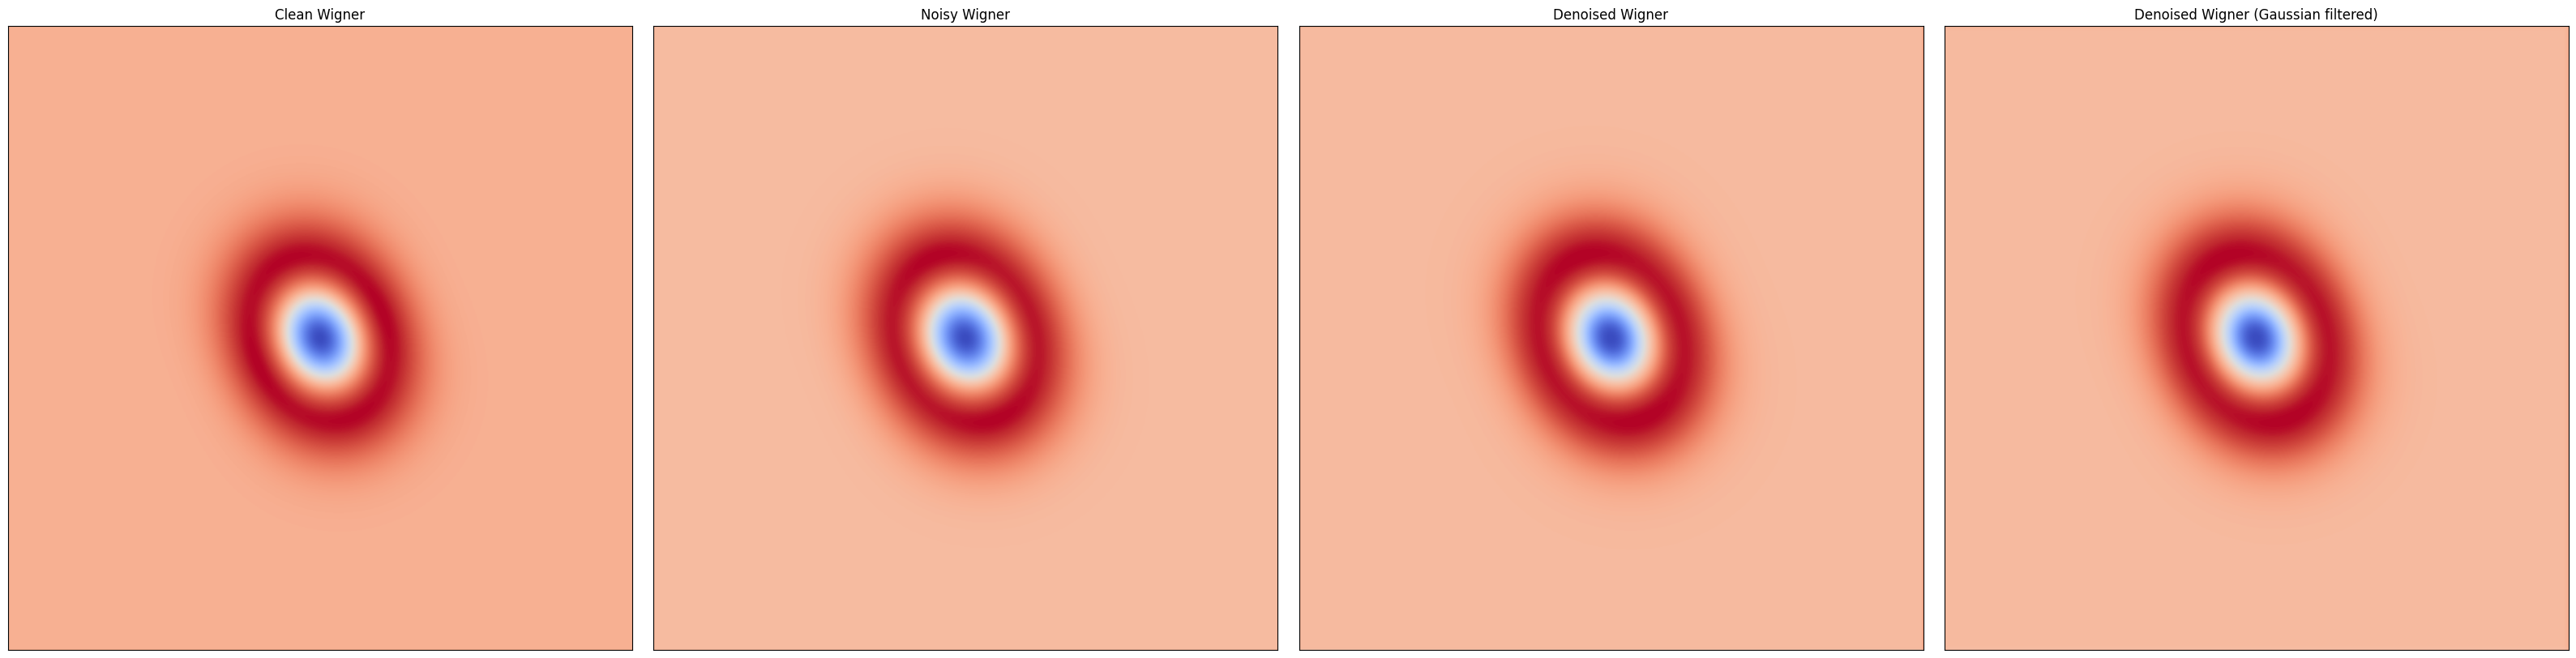

In [72]:
state_dict = torch.load("model.pth")

# If 'module.' prefix is there, strip it
from collections import OrderedDict
new_state_dict = OrderedDict()

for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove 'module.' prefix
    new_state_dict[new_key] = v

# Create model and load updated state dict
model = SimpleUNet()
model.load_state_dict(new_state_dict)

model.eval()
model.to(device)

# Generate a new Wigner function for testing
xvec = np.linspace(-5, 5, 1000)
alpha = np.random.rand() + 1j * np.random.rand()
psi = (coherent(15, alpha) - coherent(15, -alpha)).unit()
clean = wigner(psi, xvec, xvec)
# Add noise
noise_fn = convo
noisy = noise_fn(clean)

# Convert to torch tensors
clean_tensor = torch.from_numpy(clean).float().unsqueeze(0).to(device)
noisy_tensor = torch.from_numpy(noisy).float().unsqueeze(0).to(device)

# Add batch dimension
clean_tensor = clean_tensor.unsqueeze(0)
noisy_tensor = noisy_tensor.unsqueeze(0)

# Pass through the model
with torch.no_grad():
    denoised_tensor = model(noisy_tensor)
    
# Convert back to numpy
denoised = denoised_tensor.cpu().numpy().squeeze()

# Apply Gaussian filter to denoised result
sigma = 3
denoised_filtered = gaussian_filter(denoised, sigma=sigma)

# Plot the results
fig, axes = plt.subplots(1, 4, figsize=(32, 8))
axes[0].imshow(clean, cmap='coolwarm')
axes[0].set_title('Clean Wigner')
axes[1].imshow(noisy, cmap='coolwarm')
axes[1].set_title('Noisy Wigner')
axes[2].imshow(denoised, cmap='coolwarm')
axes[2].set_title('Denoised Wigner')
axes[3].imshow(denoised_filtered, cmap='coolwarm')
axes[3].set_title('Denoised Wigner (Gaussian filtered)')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()
